# Разработка A/B-тестирования и анализ результатов


### Цели и задачи проекта
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

Задачи:
1. Загрузить данные и Провести предобработку данных.
2. Провести исследовательский анализ данных.
3. Мониторинг А/В-теста.
4. Проверка результатов А/В-теста
5. Сформулировать выводы по А/В-тесту.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


### 1. Работа с историческими данными (EDA)

In [1]:
# Испортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from statsmodels.stats.power import NormalIndPower
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

In [2]:
# Создадим датафрейм sessions_history
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

In [3]:
# Выведем первые 5 строк датафрейма
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Выведем информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


In [5]:
# Выведем сводную описательную статистику по датафрейму
sessions_history.describe()

,session_number,registration_flag,page_counter
count,435924.000000,435924.000000,435924.000000
mean,2.382908,0.077325,3.005561
std,1.288487,0.267107,1.024625
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,3.000000
75%,3.000000,0.000000,4.000000
max,10.000000,1.000000,7.000000


#### 1.2. Знакомство с данными


In [6]:
# Проверим датафрейм на явные дубликаты
sessions_history.duplicated().sum()

0

In [7]:
# Проверим на неявные дубликаты
sessions_history.duplicated(subset=['user_id', 'session_id']).sum()

0

Дубликатов нет

In [8]:
# Найдем количество уникальных сессий для пользователей
user_session_counts = sessions_history.groupby('user_id')['session_id'].nunique()

In [9]:
# Найдем пользователя с максимальны количеством сессий
max_sessions_user = user_session_counts.idxmax()

In [10]:
# Выведем данные пользователя с максимальным количеством сессий
result = sessions_history[sessions_history['user_id'] == max_sessions_user]
display(result)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций

In [11]:
# Преобразуем тип данных столбцов session_date и install_date в формат datetime
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date'])

In [12]:
# Подсчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения
daily_stats = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'count'),
    registred_users=('registration_flag', 'sum')
).reset_index()

In [13]:
# Подсчитаем долю зарегистрированных пользоватлей от всех пользователей
daily_stats['registration_ratio'] = daily_stats['registred_users'] / daily_stats['total_users']

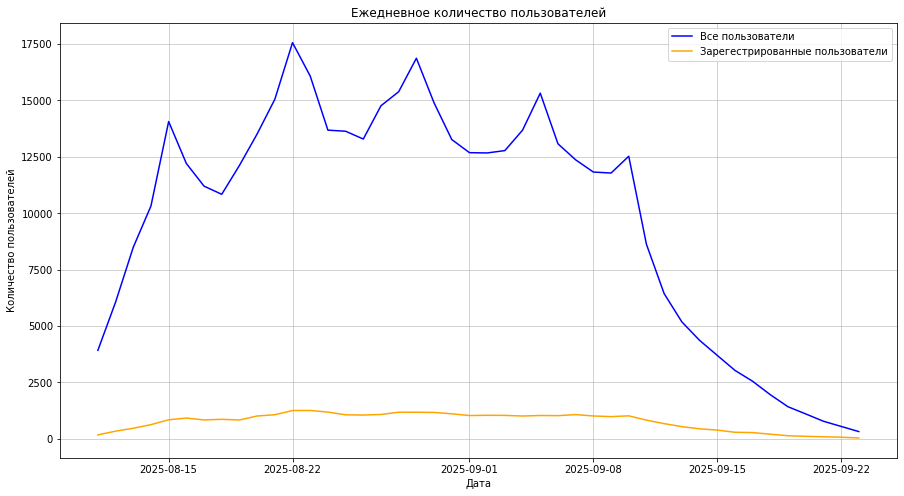

In [14]:
# Посстроим график общего числа пользователей и общего числа зарегистрированных пользователей по дням
plt.figure(figsize=(15, 8))

plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Все пользователи', color='blue')
plt.plot(daily_stats['session_date'], daily_stats['registred_users'], label='Зарегестрированные пользователи', color='orange')

plt.title('Ежедневное количество пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.7)
plt.legend()
plt.show()

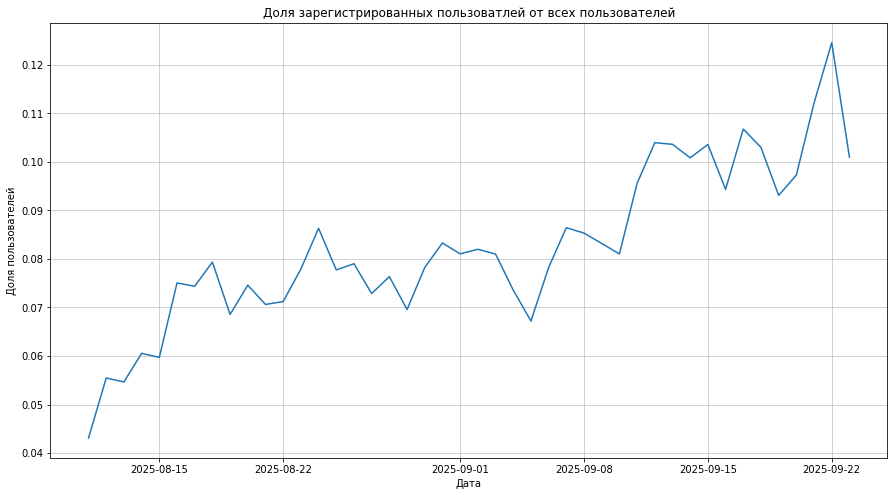

In [15]:
# Построим график доли зарегистрированных пользоватлей от всех пользователей
plt.figure(figsize=(15, 8))

plt.plot(daily_stats['session_date'], daily_stats['registration_ratio'])
plt.title('Доля зарегистрированных пользоватлей от всех пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля пользователей')
plt.grid(True, alpha=0.7)
plt.show()

#### 1.4. Анализ числа просмотренных страниц

In [16]:
# Найдем количество сессий для каждого значения количества просмотренных страниц
page_stats = sessions_history.groupby('page_counter')['session_id'] \
                                                        .count().reset_index() \
                                                        .rename(columns={'session_id': 'session_count'})

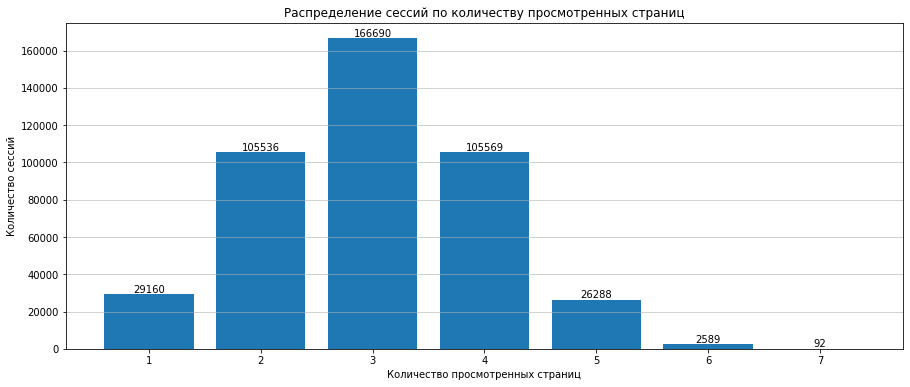

In [17]:
# Построим столбчатую диаграмму
plt.figure(figsize=(15, 6))

bars = plt.bar(page_stats['page_counter'], page_stats['session_count'])

# Добавляем подписи значений (код ревьюера)
for i, v in enumerate(page_stats['session_count']):
    plt.text(page_stats['page_counter'][i], v, str(v), ha='center', va='bottom')                  

# Оформление
plt.title('Распределение сессий по количеству просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y', alpha=0.7)
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

In [18]:
# Создадим дополнительный столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

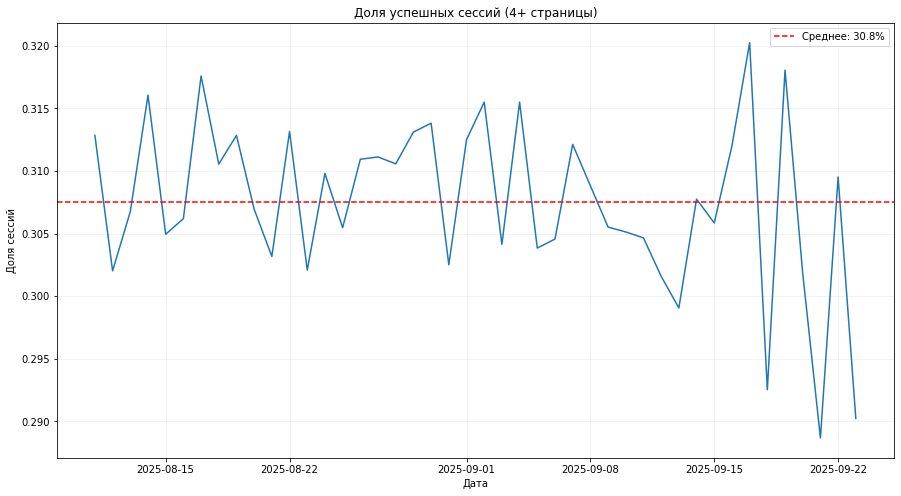

In [19]:
# Подсчитаем количество успешных сессий и всех сессий
daily_stats = sessions_history.groupby('session_date')['good_session'].agg([
    ('total_sessions', 'count'),
    ('good_sessions', 'sum')
]).reset_index()

# Подсчитаем долю успешных сессий ко всем сессиям
daily_stats['good_sessions_ratio'] = daily_stats['good_sessions'] / daily_stats['total_sessions']

# Посчитаем среднее значение доли успешных сессий
mean_sessions_ratio = daily_stats['good_sessions_ratio'].mean()

# Построим график доли успешных сессий ко всем сессиям
plt.figure(figsize=(15, 8))

plt.plot(daily_stats['session_date'], daily_stats['good_sessions_ratio'])
plt.axhline(mean_sessions_ratio, color='red', linestyle='--', 
           label=f'Среднее: {mean_sessions_ratio:.1%}')
plt.title('Доля успешных сессий (4+ страницы)')
plt.xlabel('Дата')
plt.ylabel('Доля сессий')
plt.grid(True, alpha=0.2)
plt.legend()

plt.show()

### 2. Подготовка к тесту

#### 2.1. Расчёт размера выборки

In [20]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

In [21]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size*2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {round(avg_daily_users)} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дня


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

Уникальные пользователи в группе A: 1477
Уникальные пользователи в группе B: 1466


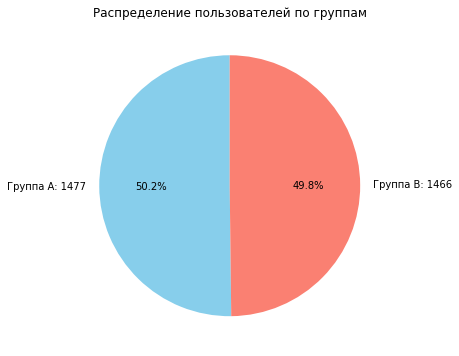

In [22]:
# Создадим датафрейм sessions_test_part
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

# Рассчитаем уникальных пользователей
test_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
test_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()

print(f"Уникальные пользователи в группе A: {test_a}")
print(f"Уникальные пользователи в группе B: {test_b}")

total_users = test_a + test_b

percent_a = round(100 * test_a / total_users, 1)
percent_b = round(100 * test_b / total_users, 1)

# Строим круговую диаграмму
plt.figure(figsize=(8, 6))
plt.pie([test_a, test_b],
        autopct='%1.1f%%',
        labels=[f'Группа A: {test_a}', 
                f'Группа B: {test_b}'],
        colors=['skyblue', 'salmon'],
        startangle=90)

plt.title(f'Распределение пользователей по группам')

plt.show()

#### 3.2. Проверка пересечений пользователей

In [23]:
# Проверим пересечение пользователей
test_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
test_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(test_a) & set(test_b))
display(intersection)

[]

Таких пользователей нет

#### 3.3. Равномерность разделения пользователей по устройствам

In [24]:
# Подсчитаем количество устройств в каждой группе
device_dist_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['device'].value_counts(normalize=True)
device_dist_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['device'].value_counts(normalize=True)

print(device_dist_a)
print(device_dist_b)

Android    0.436751
PC         0.252330
iPhone     0.204394
Mac        0.106525
Name: device, dtype: float64
Android    0.444103
PC         0.246929
iPhone     0.187961
Mac        0.121007
Name: device, dtype: float64


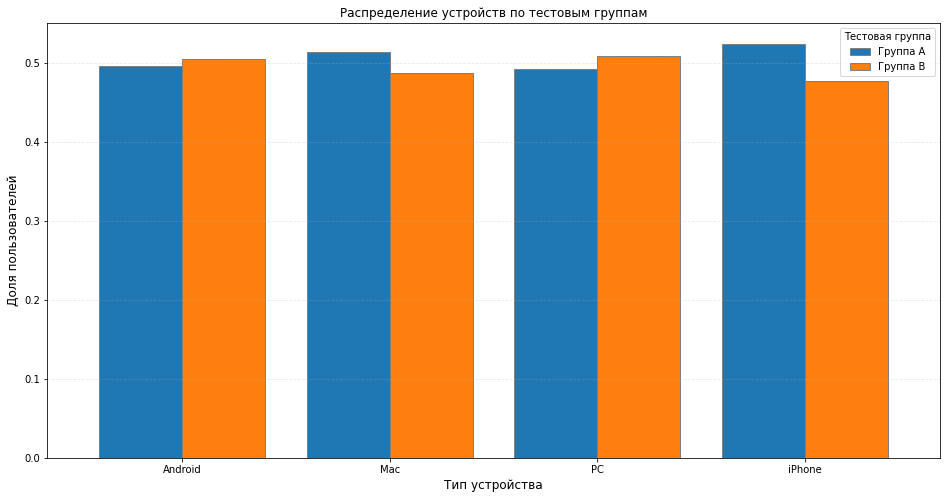

In [25]:
# Выбираем уникальные пары
users_devices = sessions_test_part.drop_duplicates(['user_id', 'device'])

# Построим график для сравнения количества устройств в группах A и B 
fig, ax = plt.subplots(figsize=(16, 8))
df_unstack = users_devices.groupby('device')['test_group'].value_counts(normalize=True).unstack(fill_value=0)

df_unstack.plot(kind='bar', width=0.8, edgecolor='grey', ax=ax) 

plt.title('Распределение устройств по тестовым группам')
plt.xlabel('Тип устройства', fontsize=12)
plt.ylabel('Доля пользователей', fontsize=12)
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.3) 
plt.legend(title='Тестовая группа', labels=['Группа A', 'Группа B'])

plt.show()

#### 3.4. Равномерность распределения пользователей по регионам

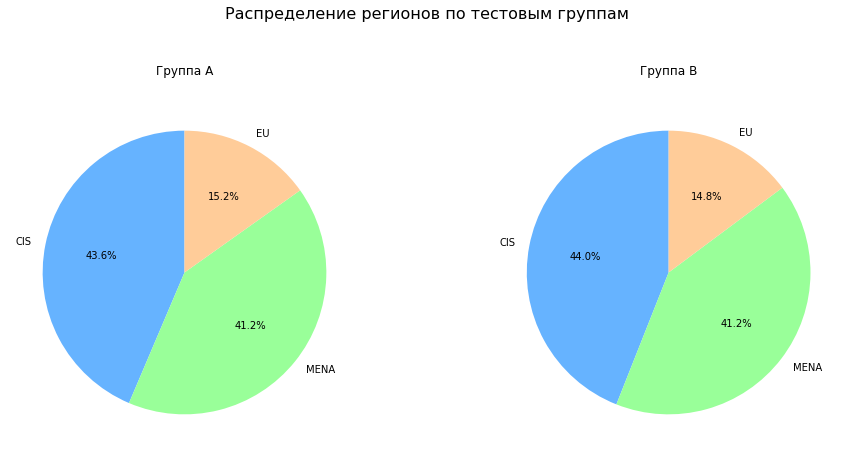

In [26]:
# Выбираем уникальные пары пользователь-регион
users_regions = sessions_test_part.drop_duplicates(subset=['user_id', 'region'])

# Подготовка данных
region_dist_a = users_regions[users_regions['test_group'] == 'A']['region'].value_counts(normalize=True)
region_dist_b = users_regions[users_regions['test_group'] == 'B']['region'].value_counts(normalize=True)

# Создаем графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Распределение регионов по тестовым группам', fontsize=16, y=1.05)

# График для группы A
ax1.pie(region_dist_a, 
        labels=region_dist_a.index,
        autopct='%1.1f%%',
        colors=['#66b3ff','#99ff99','#ffcc99'],
        startangle=90)
ax1.set_title('Группа A', pad=20)

# График для группы B
ax2.pie(region_dist_b, 
        labels=region_dist_b.index,
        autopct='%1.1f%%',
        colors=['#66b3ff','#99ff99','#ffcc99'],
        startangle=90)
ax2.set_title('Группа B', pad=20)

plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

#### На основе проведённого анализа A/B-теста получили следующие выводы:

 - между группами существует небольшая разница в 11 человек, В относительном значении разница в 0.2 процента. Разница статистически незначима, группы сбалансированы по объёму

 - между группами не было обнаружено пересечений пользователей
 
 - есть небольшие отличия между тестовой и контрольной группой по распределению пользователей по устройствам и регионам. Но оно небольшое и им можно пренебречь
 
 A/B-тест проводится корректно. Нарушений в дизайне эксперимента не обнаружено

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [27]:
# Создадим датафрейм sessions_test
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

# Создадим столбец good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

#### 4.2. Проверка корректности результатов теста

In [28]:
# Выведем информацию о датафрейме
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
 11  good_session       100005 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.2+ MB


In [29]:
# Приведем столбец session_start_ts к типу datetime
sessions_test['session_start_ts'] = pd.to_datetime(sessions_test['session_start_ts'])

In [30]:
# Временной диапазон теста
min_date = sessions_test['session_start_ts'].min()
max_date = sessions_test['session_start_ts'].max()
print(f"Временной диапазон теста:\nОт {min_date} до {max_date}")

Временной диапазон теста:
От 2025-10-14 00:00:04 до 2025-11-02 23:47:33


Из описания задачи тест проводился с 2025-10-14 по 2025-11-02. По данным датафрейма все верно.

In [31]:
# Рассчитаем количество уникальных сессий для каждого дня для обеих групп
daily_session_a = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date')['session_id'].nunique()
daily_session_b = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date')['session_id'].nunique()


test_result = ttest_ind(
    daily_session_a,
    daily_session_b,
    alternative='two-sided' 
)

alpha = 0.05

if test_result.pvalue > alpha:
    print(f"Вывод: p-value = {test_result.pvalue} > {alpha} → Нет статистически значимых различий")
    print("Тест проводится корректно, группы сбалансированы по количеству сессий")
else:
    print(f"Вывод: p-value = {test_result.pvalue} ≤ {alpha} → Обнаружены значимые различия")
    print("Внимание! Группы не сбалансированы, требуется проверка дизайна эксперимента")

Вывод: p-value = 0.938219304859116 > 0.05 → Нет статистически значимых различий
Тест проводится корректно, группы сбалансированы по количеству сессий


#### 4.3. Сравнение доли успешных сессий

In [32]:
# Рассчитаем долю успешных ссесий
results = sessions_test.groupby('test_group')['good_session'].agg([
    ('total_sessions', 'count'),
    ('good_sessions', 'sum'),
    ('good_ratio', 'mean')
])

display(results)

# Рассчитаем разницу доли успешных сессий для групп А и B 
diff_ratio = results.loc['B', 'good_ratio'] - results.loc['A', 'good_ratio']

display(f'Разница успешных сессий среди групп составлет: {diff_ratio}')

,total_sessions,good_sessions,good_ratio
test_group,,,
A,49551,15248,0.307723
B,50454,16059,0.318290


'Разница успешных сессий среди групп составлет: 0.010566571724179463'

#### 4.4. Насколько статистически значимо изменение ключевой метрики

In [33]:
# Проверим является ли разница в выборках статистически значимой
z_stat, p_value = proportions_ztest(
    [results.loc['A', 'good_sessions'], results.loc['B', 'good_sessions']],
    [results.loc['A', 'total_sessions'], results.loc['B', 'total_sessions']],
    alternative='two-sided'
)

print(f"Z-тест пропорций: p-value = {p_value}")
if p_value < 0.05:
    print("Вывод: Разница статистически значима (p < 0.05)")
else:
    print("Вывод: Разница не статистически значима (p ≥ 0.05)")

Z-тест пропорций: p-value = 0.0003149479976072246
Вывод: Разница статистически значима (p < 0.05)


#### 4.5. Вывод по результатам A/B-эксперимента

#### Выводы по результатам A/B-теста
 - всего было задействовано более 34 882 пользователей, эксперимент проводился 4 дня. В группах А и B было 1477 и 1466 пользователей соответственно, пересечений не было, распределение по устройствам и регионам было сбалансированным
 - внедрение алгоритма повлияло на рост ключевой метрики, доля успешных сессий, т.е. сессий где число просмотренных страниц более 4. Разница между тестовыми группами составила чуть более 1 процента
 - p-value = 0.0003, что говорит о том, что разница между группами статистически значима.

Учитывая полученные результаты, рекомендуется внедрить новоовведение в продукт. Небольшой прирост успешности сессий в 1% является статистически значимым улучшением, что способствует повышению вовлечённости пользователей и потенциально увеличивает ключевые показатели эффективности приложения.